In [130]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

In [131]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

In [132]:
# 이미지를 내려받아 넘파이 배열로 변환
def download(url, max_dim = None):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin = url)
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

# 이미지를 정규화
def deprocess(img):
    img = 255 * (img + 1.0) / 2.0
    return tf.cast(img, tf.uint8)

# 이미지를 출력합니다.
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))
    

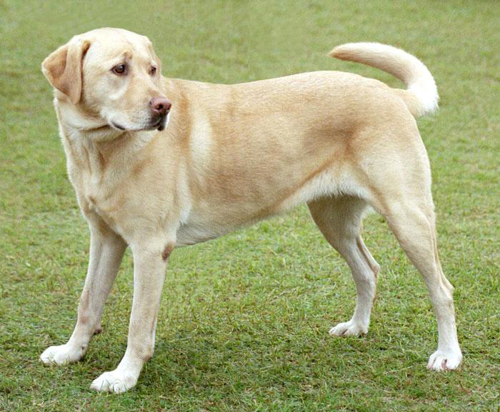

In [133]:
# 이미지의 크기를 줄여 작업이 더 용이하도록 만듬
original_img = download(url, max_dim = 500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

In [134]:
import tensorflow as tf
from tensorflow import Module 
from tensorflow.keras.applications import inception_v3
from tensorflow.keras import backend as k

In [135]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [136]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_752 (Conv2D)            (None, None, None,   864         ['input_9[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_752 (Batch  (None, None, None,   96         ['conv2d_752[0][0]']             
 Normalization)                 32)                                                    

In [137]:
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

dream_model = tf.keras.Model(inputs = base_model.input, outputs = layers)

In [138]:
def calc_loss(img, model):
    # 이미지를 순전파시켜 모델의 활성화값을 얻습니다.
    # 이미지의 배치(batch) 크기를 1로 만듭니다.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [139]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
    def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # `img`에 대한 그래디언트가 필요합니다.
          # `GradientTape`은 기본적으로 오직 `tf.Variable`만 주시합니다.
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # 입력 이미지의 각 픽셀에 대한 손실 함수의 그래디언트를 계산합니다.
        gradients = tape.gradient(loss, img)

        # 그래디언트를 정규화합니다.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        # 경사상승법을 이용해 "손실" 최대화함으로써 입력 이미지가 선택한 층들을 보다 더 "흥분" 시킬 수 있도록 합니다.
        # (그래디언트와 이미지의 차원이 동일하므로) 그래디언트를 이미지에 직접 더함으로써 이미지를 업데이트할 수 있습니다.
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [140]:
deepdream = DeepDream(dream_model)

In [141]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
      # 이미지를 모델에 순전파하기 위해 uint8 형식으로 변환합니다.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))

    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

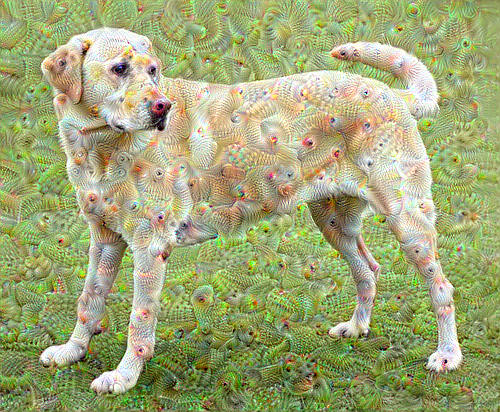

In [142]:
dream_img = run_deep_dream_simple(img=original_img, steps =100, step_size=0.01)

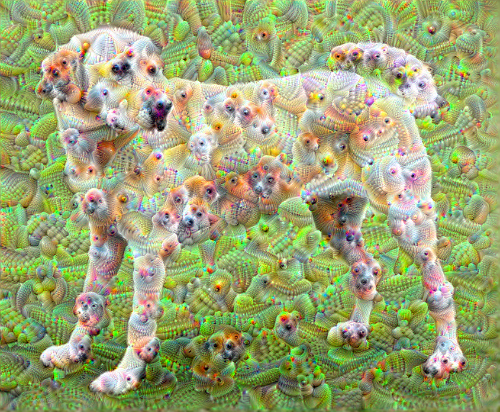

7.5202436447143555

In [143]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
    new_shape = tf.cast(float_base_shape * (OCTAVE_SCALE**n), tf.int32)
    img = tf.image.resize(img, new_shape).numpy()
    img = run_deep_dream_simple(img = img, steps=50, step_size=0.01)
    
display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype = tf.uint8)
show(img)

end = time.time()
end - start